# Chinese character image data
## Loading images, basic stats and visualizing the characters.
### John Burt

### December 2018


[To hide code cells, view this in nbviewer](https://nbviewer.jupyter.org/github/johnmburt/projects/tree/master/chinese_characters/JMB_chinese_char_evolution_load_vf.ipynb) 

#### Notebook purpose: 

Just doing some data exploration, conversion and visualization.

- Read PNG image file directories, parse filenames to create pandas dataframe with sample info.

- Category (character ID and era) frequency stats.

- Find characters that have a minimum number of examples. 

- Visualize the character dataset 

In [1]:
# javascript to hide / show notebook code
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [2]:
# basic notebook setup

# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np


### Parse datafiles to create sample info dataframe



In [3]:
import os
import re

code = [] # character code (converted to int)
era = [] # era
index = [] # index of sample for this code and era
path = [] # file path to read image data

sourcetop = 'ch_train_set' # name of dir holding image data

# Seek through data folder for PNG files
for dirpath, dirnames, filelist in os.walk(top=sourcetop):
    # change any \ to /
    srcdir = dirpath.replace('\\','/')
    # look for any PNG files in the current folder
    for fname in filelist:
        if fname[-3:]=='png':
            # parse filename to get image category data
            parts = re.split('/|-|_|\.',fname)
            # files with category info in filename
            if len(parts) > 2:
                # get image file path
                path.append(srcdir+'/'+fname)
                code.append(int(parts[0], 16)) # convert character code str to int
                era.append(parts[1])
                index.append(int(parts[2]))  
            # modern figure image file
            else:
                path.append(srcdir+'/'+fname)
                code.append(int(parts[0], 16)) # convert character code str to int
                era.append('modern')
                index.append(0)    

# create info dataframe
df = pd.DataFrame( 
    {
    'code' : code, 
    'era' : era, 
    'id' : index, 
    'path' : path
    } )

df.head()

,code,era,id,path
0,42048,chuxi,1,ch_train_set/a440/a440-chuxi_001.png
1,42048,chuxi,2,ch_train_set/a440/a440-chuxi_002.png
2,42048,chuxi,4,ch_train_set/a440/a440-chuxi_004.png
3,42048,chuxi,5,ch_train_set/a440/a440-chuxi_005.png
4,42048,chuxi,6,ch_train_set/a440/a440-chuxi_006.png


###  Sample frequencies of characters

Histogram of # samples of each character code (all eras combined).

Note: there is one character code that has 710 samples. I excluded it from the histo range.

min #samples: 10, max #samples: 710



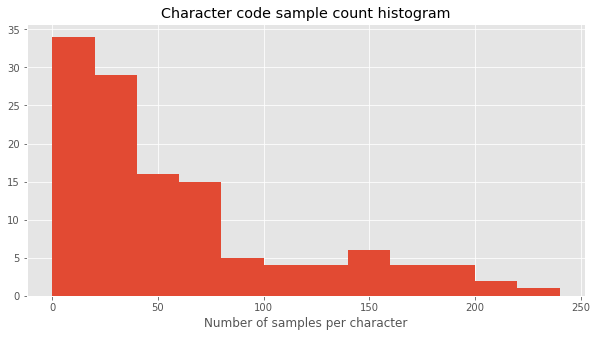

In [10]:
codes = df.code.unique() # get list of codes
counts = []
# cound samples of each code
for code in codes:
    counts.append((df.code==code).sum())

# sort list by sample counts, descending order
idx =  np.flip(np.argsort(counts), axis=0)

print('min #samples: %d, max #samples: %d\n'%(min(counts), max(counts)))

plt.figure(figsize=(10,5))
pd.Series(counts)[np.argsort(counts)].hist(bins=list(range(0,250,20)));
plt.xlabel('Number of samples per character')
plt.title('Character code sample count histogram');


### List character codes that meet a specified minimum sample criteria

There are some characters with very few samples (including just one sample). For training and testing, I only want to work with characters with a sufficient number of samples, so I wrote this to do that.

In [11]:

# specify here the min # samples for each era:
#  chuxi, jinwen, oracle, smallseal
minsamples = [50, 50, 0, 0]

okcodes = []

print('Characters that met the criteria:\n')
print('code\t#chuxi\t#jinwen\t#oracle\t#smallseal')
for code in codes[idx]:
    if ((df.id[(df.code==code) & (df.era=='chuxi')].unique().shape[0] >= minsamples[0]) &
        (df.id[(df.code==code) & (df.era=='jinwen')].unique().shape[0] >= minsamples[1]) &
        (df.id[(df.code==code) & (df.era=='oracle')].unique().shape[0] >= minsamples[2]) &
        (df.id[(df.code==code) & (df.era=='smallseal')].unique().shape[0] >= minsamples[3]) 
       ):
        okcodes.append(code)
        print('%4X\t%3d\t%3d\t%3d\t%3d'%(
            code, 
            df.id[(df.code==code) & (df.era=='chuxi')].unique().shape[0],
            df.id[(df.code==code) & (df.era=='jinwen')].unique().shape[0],
            df.id[(df.code==code) & (df.era=='oracle')].unique().shape[0],
            df.id[(df.code==code) & (df.era=='smallseal')].unique().shape[0],
        ))
        
print("\n%d codes met min criteria of "%(len(okcodes)),minsamples)


Characters that met the criteria:

code	#chuxi	#jinwen	#oracle	#smallseal
A4A7	603	105	  1	  0
A4EB	102	107	  2	  0
A453	145	 61	  1	  0
A548	142	 52	  2	  0
A46C	 63	124	  2	  3
B6C0	110	 54	  2	  2
B0A8	 94	 67	  1	  3
AAF7	 78	 83	  0	  2
A4A3	100	 55	  2	  0
A4BD	 85	 67	  1	  0
A4FD	 60	 79	  3	  2

11 codes met min criteria of  [50, 50, 0, 0]


### Load image data into numpy array

Convert so that ink = 1, whitespace = 0

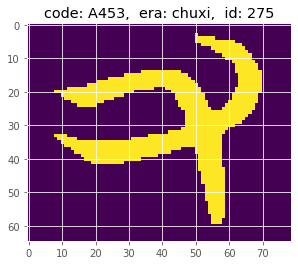

In [24]:
from PIL import Image

codeindex = 750

# read image, convert to int, and invert so that 1=ink, 0=whitespace
arr = np.asarray(Image.open(df.path[codeindex])).astype(int)

plt.imshow(arr)
plt.title('code: %X,  era: %s,  id: %d'%(df.code[codeindex], df.era[codeindex], df.id[codeindex]));
                                         

### View some images

View the top N characters that met the above criteria

Note: I use the PIL module here for image display instead of scipy imageio, even though it's a bit of a pain, because imageio is being depreciated and so the code will eventually break if it is used.

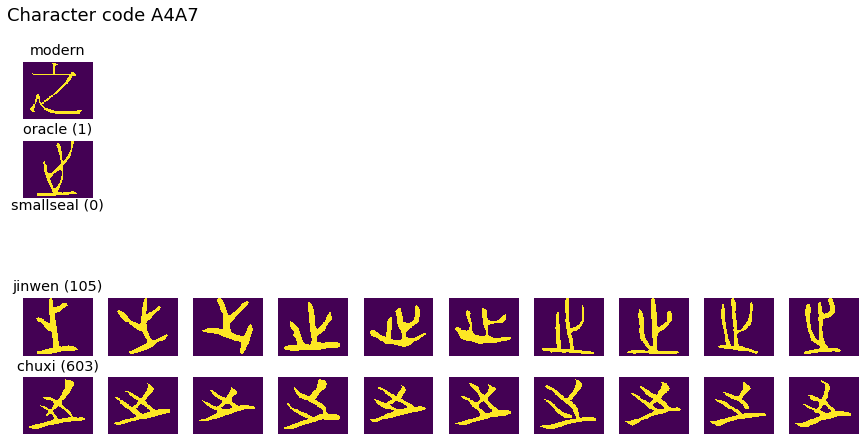

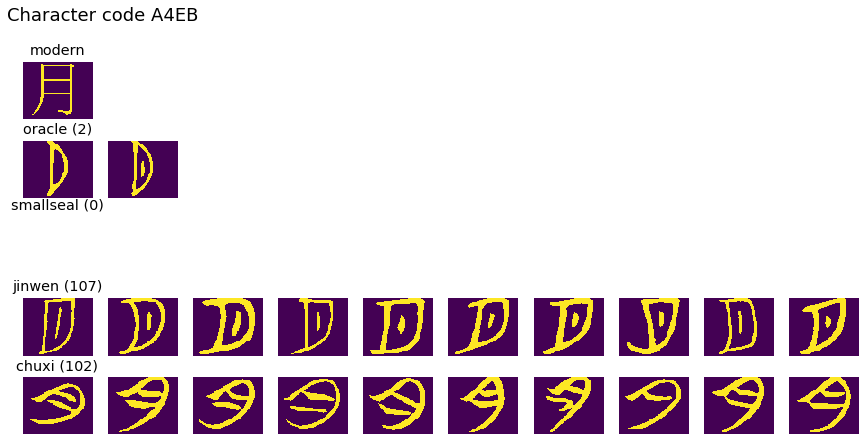

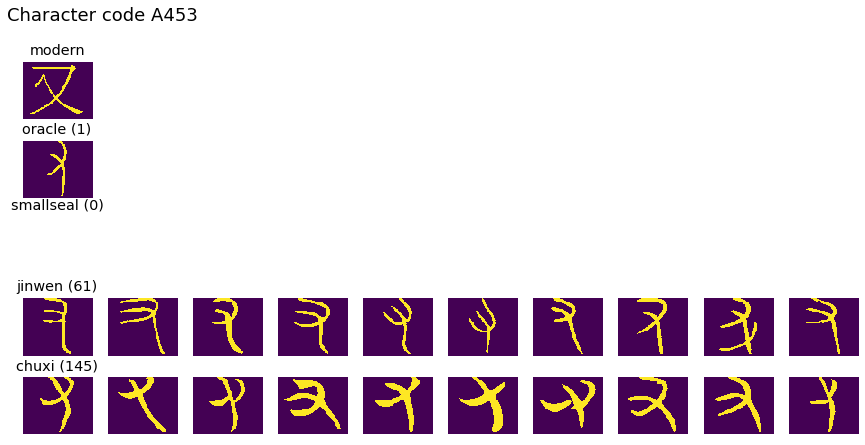

In [7]:
from PIL import Image

# view this many examples of each character code and era
numcols = 10 

# max number of characters to view
maxcodes = 3

# display examples of each of the most sampled codes
for code in okcodes[:maxcodes]:
    f, axes = plt.subplots(5,numcols,figsize=(15,7),subplot_kw={'xticks': [], 'yticks': [], 'fc':'none'})
    f.suptitle('Character code %X'%(code), x=.2, fontsize=18)
    
    # display the modern character exmple (there's only one)
    modernpath = df.path[(df.code==code) & (df.era=='modern')].values[0]
    axes[0, 0].imshow(Image.open(modernpath))
    axes[0, 0].set_title('modern')
        
    # display examples of each era, if there are any
    for era,eranum in zip(['oracle', 'smallseal', 'jinwen', 'chuxi'], range(4)):
        # get paths of example images of this code and era
        paths = df.path[(df.code==code) & (df.era==era)].values
        # check whether there are any examples
        if paths.shape[0]:
            # display up to numcols examples
            for i in range(min(numcols,paths.shape[0])):
                # read the image from file and then show it in the plot axis
                axes[eranum+1, i].imshow(Image.open(paths[i]))
        # indicate era and # samples in title of first example 
        axes[eranum+1, 0].set_title(era+' (%d)'%paths.shape[0])
        
    plt.show();

